In [ ]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qutip import *
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings('ignore')
from itertools import product

In [174]:
def states_to_df(states,times):
    data = {}
    for i in range(0,states[0].shape[0]):
        which_mode = divmod(i,2)
        if which_mode[1] == 0:
            two_state = "+"
        elif which_mode[1] == 1:
            two_state = "-"
        data[str(which_mode[0])+" , "+two_state] = np.zeros(len(times),dtype="complex128")
    
    for i, state in enumerate(states):
        for j, psi in enumerate(state):
            which_mode = divmod(j,2)
            if which_mode[1] == 0:
                two_state = "+"
            elif which_mode[1] == 1:
                two_state = "-"
            data[str(which_mode[0])+" , "+two_state][i] = psi[0][0]

    return pd.DataFrame(data=data, index=times)

Let's remind ourselves of the Hamiltonian that we've been working with:

$$H =  A \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + \frac{\delta}{2}\left( a^{\dagger} + a \right)\sigma_x$$

The reason we chose A and $\delta$ is because of the path of discovery that we've taken to get here. From now on it will be convenient for us to re-write the Hamiltonian as:

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

where we recognise  $\Delta E$ as the difference in energy of our two state system which we will set as $\Delta E = 1$.


In [191]:
delta_E = 1.0            # two level energy difference
N = 1                    # number of phonon quanta needed to exite the atom
omega = delta_E / N          # phonon energy
max_bosons =  6             # Max mode number to simulation
ng = 100                  # number of different coupling strengths to try out (need 100 to reproduce SJByrnes Moiré pattern)
delta_min = 0.01    # min atom phonon coupling
delta_max = 1*delta_E     # maximum atom phonon coupling

In [192]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())             # tensorised sigma_x operator
sz = tensor(qeye(max_bosons+1),sigmaz())              # tensorised sigma_z operator

two_state     =  delta_E/2*sz                          # two state system energy
bosons       =  omega*(a.dag()*a+0.5)          # bosons field energy
interaction   = (a.dag() + a) * sx     # interaction energy

number           = a.dag()*a  # phonon number operator
spin          = sz/2       # z component of spin

In [193]:
H = two_state + bosons + interaction

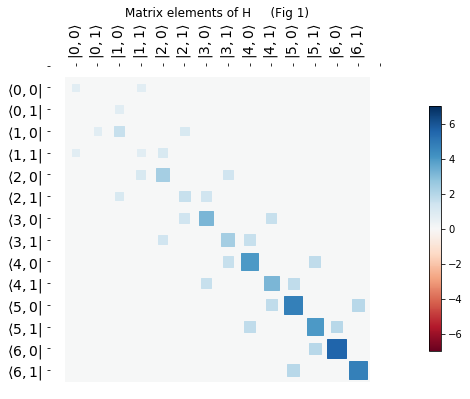

In [194]:

f, ax = hinton(H)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

In [195]:
parity = "even"

In [196]:
#inspired by SJB code https://github.com/sbyrnes321/cf/blob/1a34a461c3b15e26cad3a15de3402142b07422d9/spinboson.py#L56
if parity != "all":
    S=1/2
    possible_ns = range(0, max_bosons+1)
    possible_ms = - (np.arange(2*S+1) - S)
    Smn_list = product([S], possible_ns, possible_ms)

    if parity == "even":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 0]
    elif parity == "odd":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 1]

    subset_idx = []
    for s in mn_from_index:
        subset_idx.append(state_number_index([max_bosons+1,2],s))
    
    # Labels for hinton plots in case we want to plot it later (use xlabels=ket_labels, ylabels = bra_labels)
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+"|" for (n,m) in mn_from_index]
    ket_labels = ["|"+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in mn_from_index]


In [197]:
    # http://qutip.org/docs/latest/apidoc/classes.html?highlight=extract_states#qutip.Qobj.extract_states
    two_state    = two_state.extract_states(subset_idx) 
    bosons      = bosons.extract_states(subset_idx) 
    interaction  = interaction.extract_states(subset_idx) 
    number          = (a.dag()*a).extract_states(subset_idx)
    spin         = spin.extract_states(subset_idx)

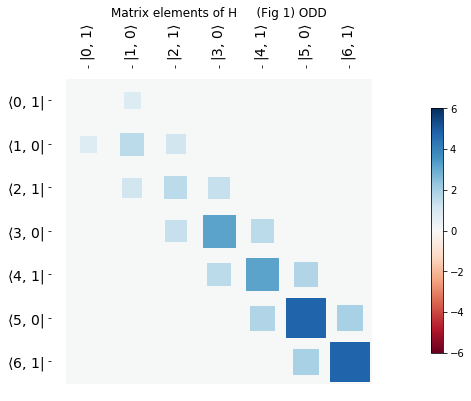

In [198]:
H = two_state + bosons + interaction
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1) ODD");

In [163]:
d = {"coupling":np.linspace(delta_min,delta_max,ng)}
for i in range((max_bosons+1)):
    d[f"level_{i}"] = np.zeros(ng)
    
df = pd.DataFrame(data=d)


# We'll create some dataframes to store expectation values for: 
df_num = pd.DataFrame(data=d) # phonon number
df_sz = pd.DataFrame(data=d)  # z component of spin
df_int = pd.DataFrame(data=d) # interaction energy

In [164]:
for index, row in df.iterrows():
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
    H = two_state + bosons + row.coupling*interaction
    evals, ekets = H.eigenstates()
    df.iloc[index,1:] = np.real(evals/omega)
    
    # We'll also calculate some expectation values so we don't have to do it later
    df_num.iloc[index,1:] = expect(number,ekets)           # phonon number
    df_sz.iloc[index,1:] = expect(spin,ekets)           # z component of spin
    df_int.iloc[index,1:] = expect(row.coupling*interaction,ekets)   # interaction energy

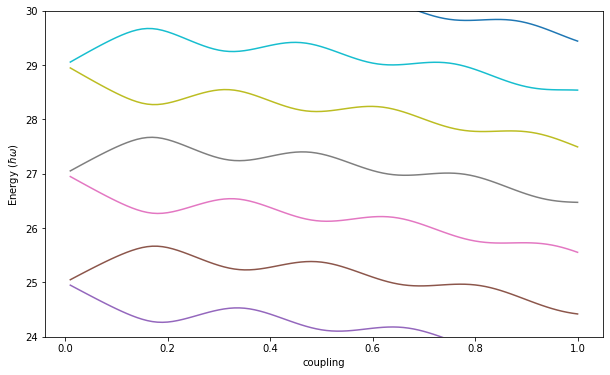

In [171]:
df.plot(x="coupling",ylim=[24,30],figsize=(10,6),legend=False);
plt.ylabel("Energy ($\hbar\omega$)");

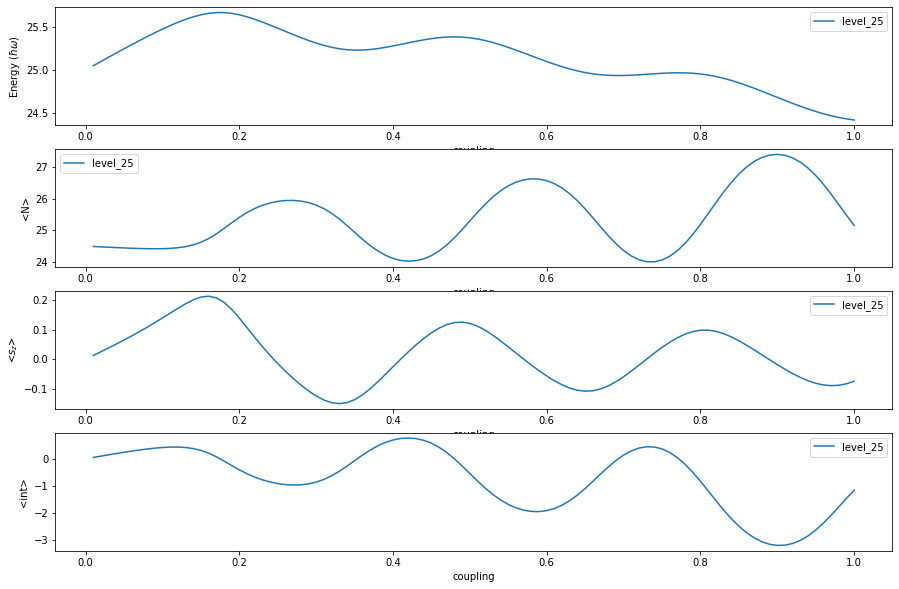

In [173]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10))
df[["coupling","level_25",]].plot(x="coupling",ax=axes[0]);
df_num[["coupling","level_25"]].plot(x="coupling",ax=axes[1]);
df_sz[["coupling","level_25"]].plot(x="coupling",ax=axes[2]);
df_int[["coupling","level_25"]].plot(x="coupling",ax=axes[3]);
axes[0].set_ylabel("Energy ($\hbar\omega$)")
axes[1].set_ylabel("<N>")
axes[2].set_ylabel("<$s_z$>");
axes[3].set_ylabel("<int>");

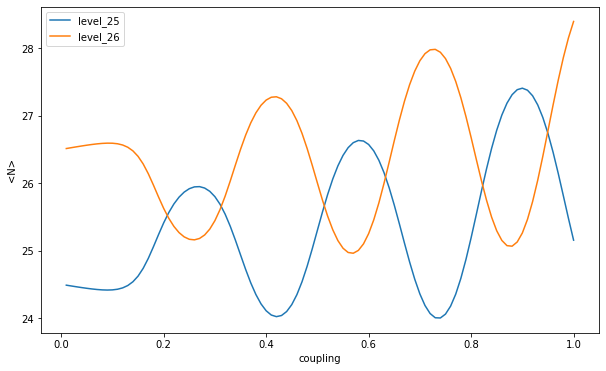

In [169]:
df_num[["coupling","level_25","level_26"]].plot(x="coupling",figsize=(10,6));
plt.ylabel("<N>");

In [127]:
H = two_state + bosons + 0.65*interaction
evals, ekets = H.eigenstates()

In [126]:
print("state", "energy", "number", "spin")
for i in range(0,5):
    print(i, evals[i]/omega, expect(number,ekets[i]), expect(spin,ekets[i]))

state energy number spin
0 0.9989995001247503 0.5002502499068735 -0.00024975015612453975
1 1.0009994998747498 0.4997502500943761 0.0002502501563748187
2 2.998267449841202 2.500433261926719 -0.00043276322351427644
3 3.001731550157298 2.4995672380769847 0.00043326322431083795
4 4.997763433418799 4.500559265278833 -0.0005587680701902692


In [108]:
print("state", "energy", "number", "spin")
for i in range(0,5):
    print(i, evals[i]/omega, expect(number,ekets[i]), expect(spin,ekets[i]))

state energy number spin
0 0.14499844258607825 0.8019347056259822 -0.08415569463832441
1 1.2707372295015946 1.0953764212669033 0.23825902174438823
2 1.876429329049736 2.2567897171081097 -0.1844385482652685
3 3.1613505509775166 4.147237447051112 0.014673501448519616
4 4.091947804168594 3.4496748333518297 0.07303371327770668


In [128]:
psi0 = tensor(basis(max_bosons+1, 1), basis(2, 1))  # No bosons and two-state system is in the higher energy + state
psi0 = psi0.extract_states(subset_idx) 

In [129]:

times = np.linspace(0.0, 10.0, 100)      # simulation time

result = sesolve(H, psi0, times)
df_coupled =  states_to_df(result.states, times)

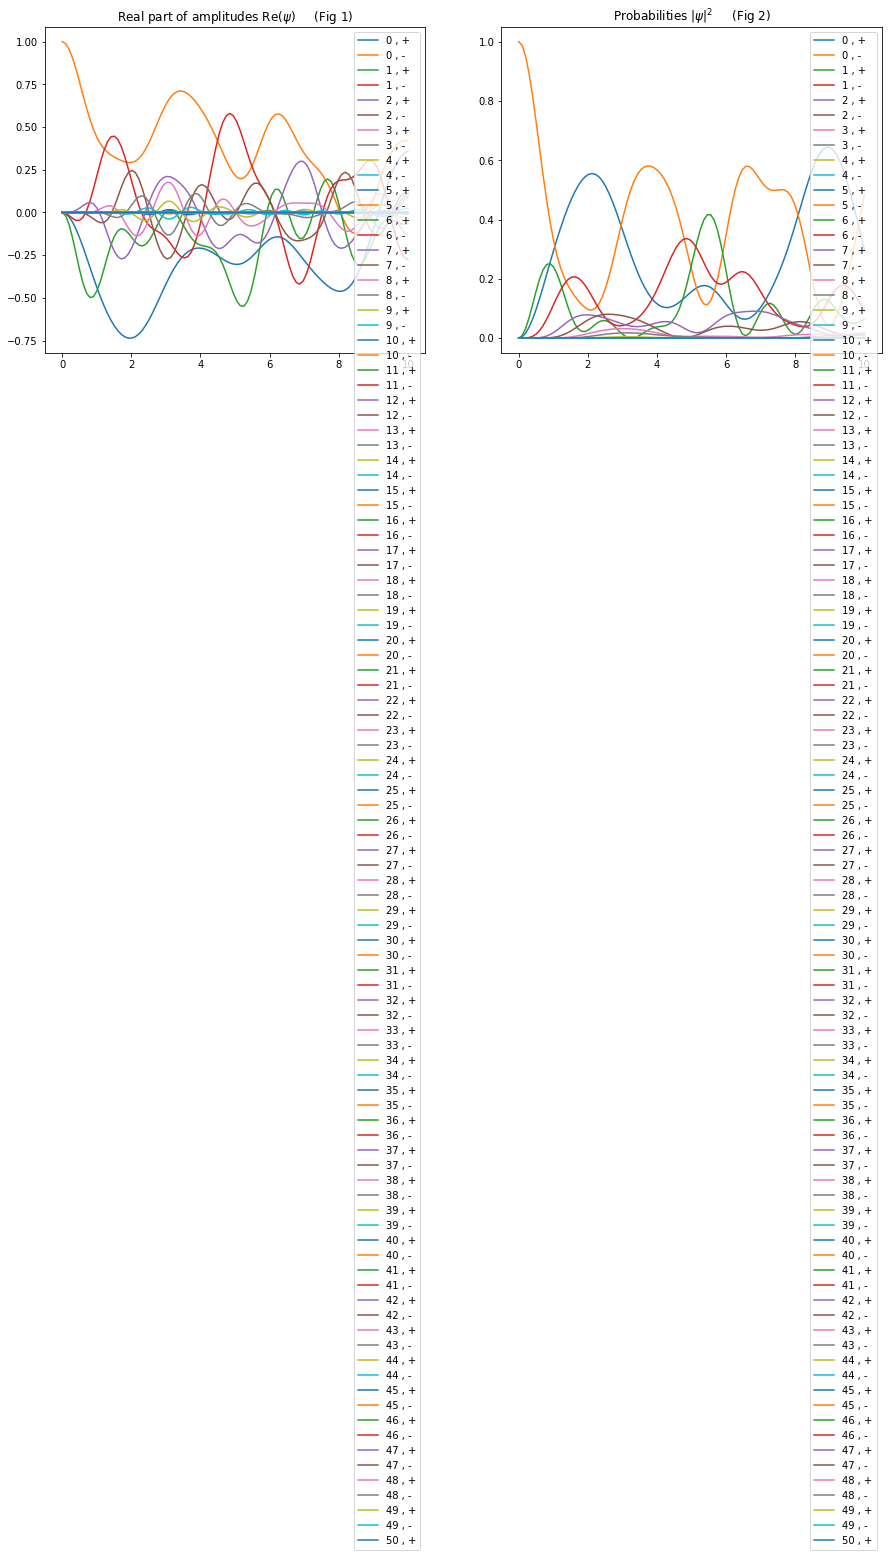

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df_coupled.plot(title="Real part of amplitudes Re($\psi$)     (Fig 1)", ax=axes[0]);
(df_coupled.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 2)", ax=axes[1]);